<a href="https://colab.research.google.com/github/Jayashreehv/ComputerVisionProjects/blob/main/multiheadattention_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
sentence = 'Life is short, eat dessert first'

dc = {s:i for i,s in enumerate(sorted(sentence.replace(',', '').split()))}
print(dc)


{'Life': 0, 'dessert': 1, 'eat': 2, 'first': 3, 'is': 4, 'short': 5}


In [2]:
print(sentence.replace(',',''))

Life is short eat dessert first


In [3]:
print(sentence.replace(',','').split())

['Life', 'is', 'short', 'eat', 'dessert', 'first']


In [4]:
print(sorted(sentence.replace(',','').split())) # sorting based on first letter ascii value of each word in the list, L ascii value < d hence at beginning, sorted (ascending)

['Life', 'dessert', 'eat', 'first', 'is', 'short']


In [5]:
import torch

In [6]:
sentence_int = torch.tensor([dc[s] for s in sentence.replace(',','').split()])
print(sentence_int)

tensor([0, 4, 5, 2, 1, 3])


In [7]:
torch.manual_seed(123)
embed = torch.nn.Embedding(6, 16)
embedded_sentence = embed(sentence_int).detach()

In [8]:
print(embedded_sentence)
print(embedded_sentence.shape)


tensor([[ 0.3374, -0.1778, -0.3035, -0.5880,  0.3486,  0.6603, -0.2196, -0.3792,
          0.7671, -1.1925,  0.6984, -1.4097,  0.1794,  1.8951,  0.4954,  0.2692],
        [ 0.5146,  0.9938, -0.2587, -1.0826, -0.0444,  1.6236, -2.3229,  1.0878,
          0.6716,  0.6933, -0.9487, -0.0765, -0.1526,  0.1167,  0.4403, -1.4465],
        [ 0.2553, -0.5496,  1.0042,  0.8272, -0.3948,  0.4892, -0.2168, -1.7472,
         -1.6025, -1.0764,  0.9031, -0.7218, -0.5951, -0.7112,  0.6230, -1.3729],
        [-1.3250,  0.1784, -2.1338,  1.0524, -0.3885, -0.9343, -0.4991, -1.0867,
          0.8805,  1.5542,  0.6266, -0.1755,  0.0983, -0.0935,  0.2662, -0.5850],
        [-0.0770, -1.0205, -0.1690,  0.9178,  1.5810,  1.3010,  1.2753, -0.2010,
          0.4965, -1.5723,  0.9666, -1.1481, -1.1589,  0.3255, -0.6315, -2.8400],
        [ 0.8768,  1.6221, -1.4779,  1.1331, -1.2203,  1.3139,  1.0533,  0.1388,
          2.2473, -0.8036, -0.2808,  0.7697, -0.6596, -0.7979,  0.1838,  0.2293]])
torch.Size([6, 16])


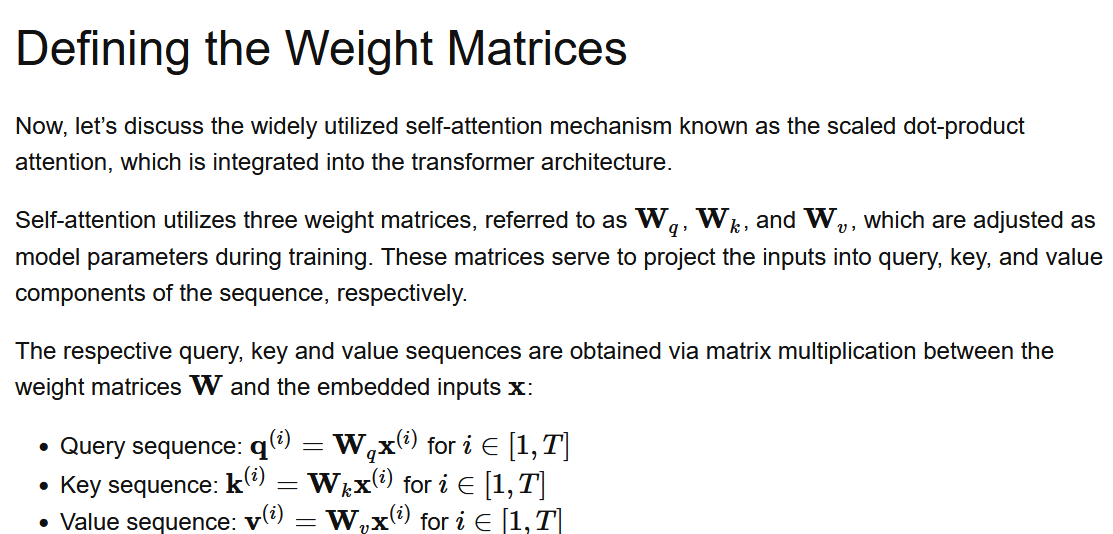

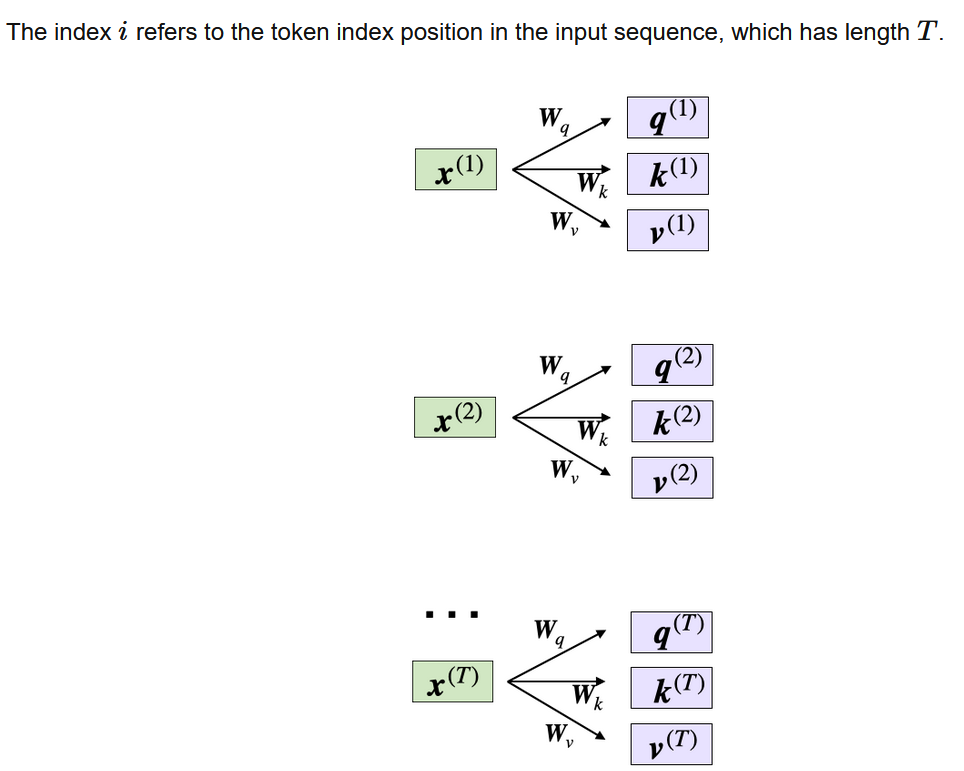

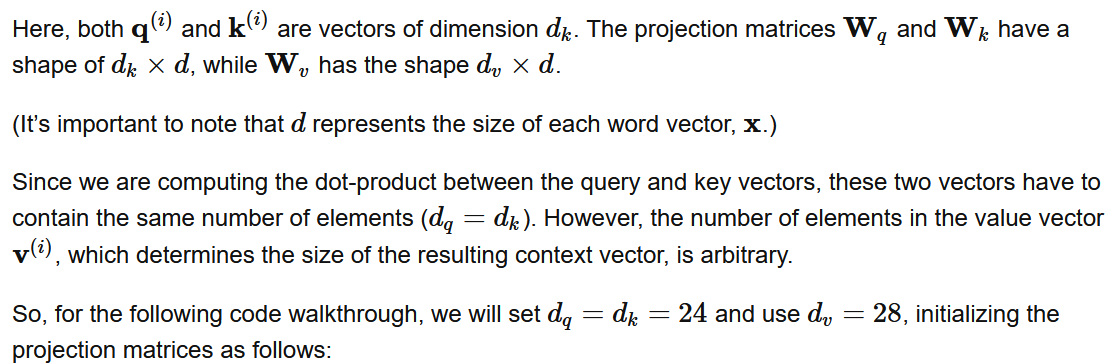

In [9]:
torch.manual_seed(123)

d = embedded_sentence.shape[1]

d_q, d_k, d_v = 24, 24, 28

W_query = torch.nn.Parameter(torch.rand(d_q, d))
W_key = torch.nn.Parameter(torch.rand(d_k, d))
W_value = torch.nn.Parameter(torch.rand(d_v, d))


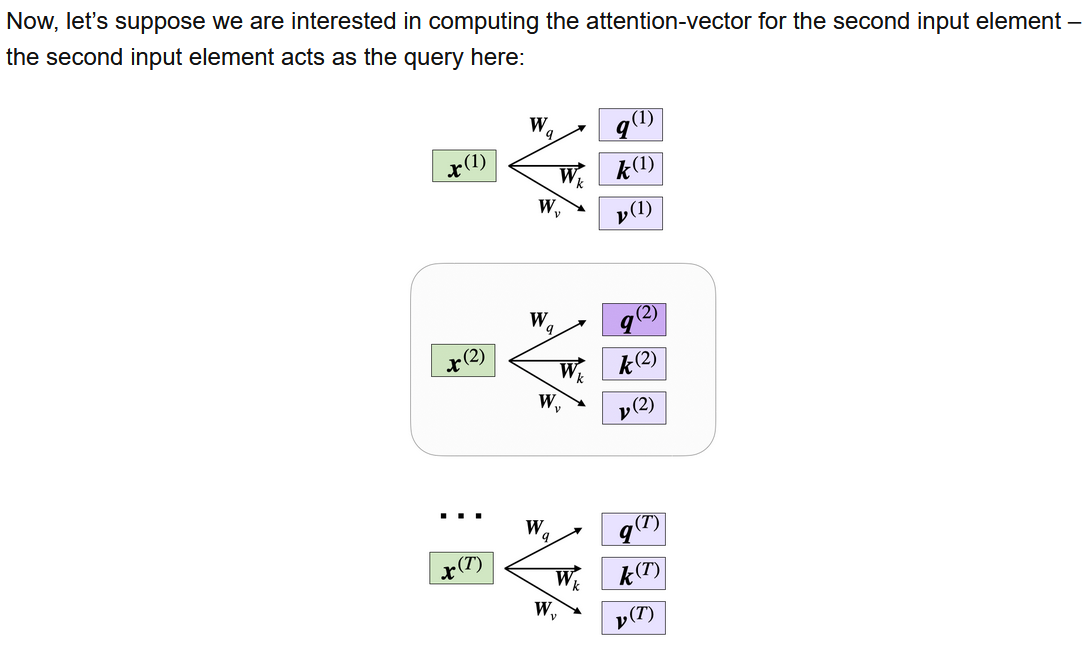

In [10]:
x_2 = embedded_sentence[1]
query_2 = W_query.matmul(x_2)
key_2 = W_key.matmul(x_2)
value_2 = W_value.matmul(x_2)

print(query_2.shape)
print(key_2.shape)
print(value_2.shape)


torch.Size([24])
torch.Size([24])
torch.Size([28])


We can then generalize this to compute th remaining key, and value elements for all inputs as well, since we will need them in the next step when we compute the unnormalized attention weights ω:

In [11]:
keys = W_key.matmul(embedded_sentence.T).T
values = W_value.matmul(embedded_sentence.T).T

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)


keys.shape: torch.Size([6, 24])
values.shape: torch.Size([6, 28])


 # Computing the Unnormalized Attention Weights #

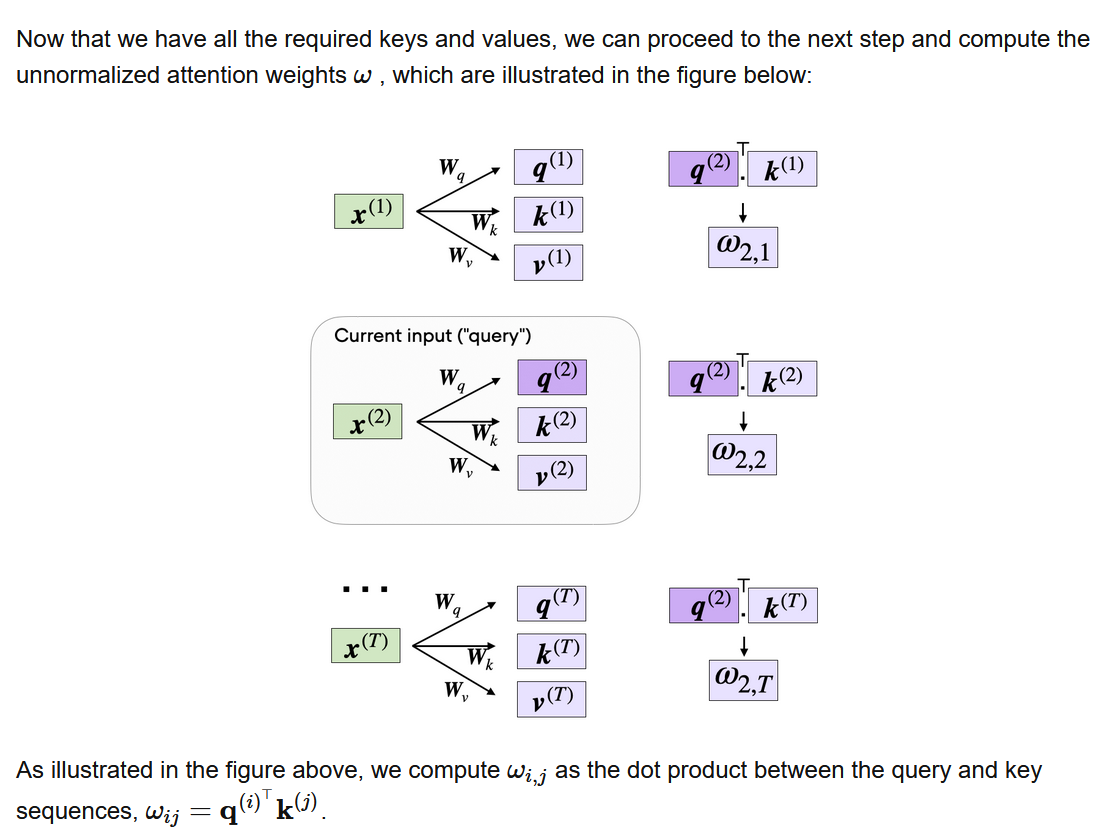

In [12]:
omega_24 = query_2.dot(keys[4])
print(omega_24)


tensor(11.1466, grad_fn=<DotBackward0>)


In [13]:
# compute the ω values for all input tokens as illustrated in the previous figure:
omega_2 = query_2.matmul(keys.T)
print(omega_2)


tensor([ 8.5808, -7.6597,  3.2558,  1.0395, 11.1466, -0.4800],
       grad_fn=<SqueezeBackward4>)


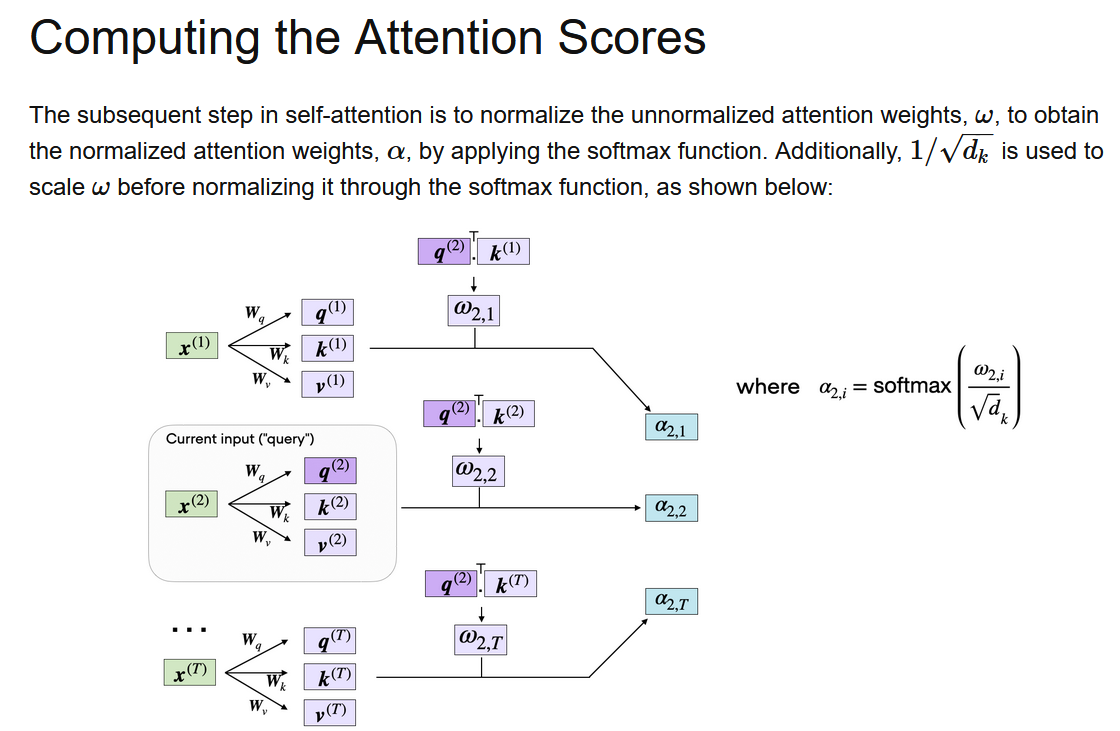[link text](https://)

The scaling by dk

ensures that the Euclidean length of the weight vectors will be approximately in the same magnitude. This helps prevent the attention weights from becoming too small or too large, which could lead to numerical instability or affect the model’s ability to converge during training.

In code, we can implement the computation of the attention weights as follows:

In [14]:
import torch.nn.functional as F

attention_weights_2 = F.softmax(omega_2 / d_k**0.5, dim=0)
print(attention_weights_2)


tensor([0.2912, 0.0106, 0.0982, 0.0625, 0.4917, 0.0458],
       grad_fn=<SoftmaxBackward0>)


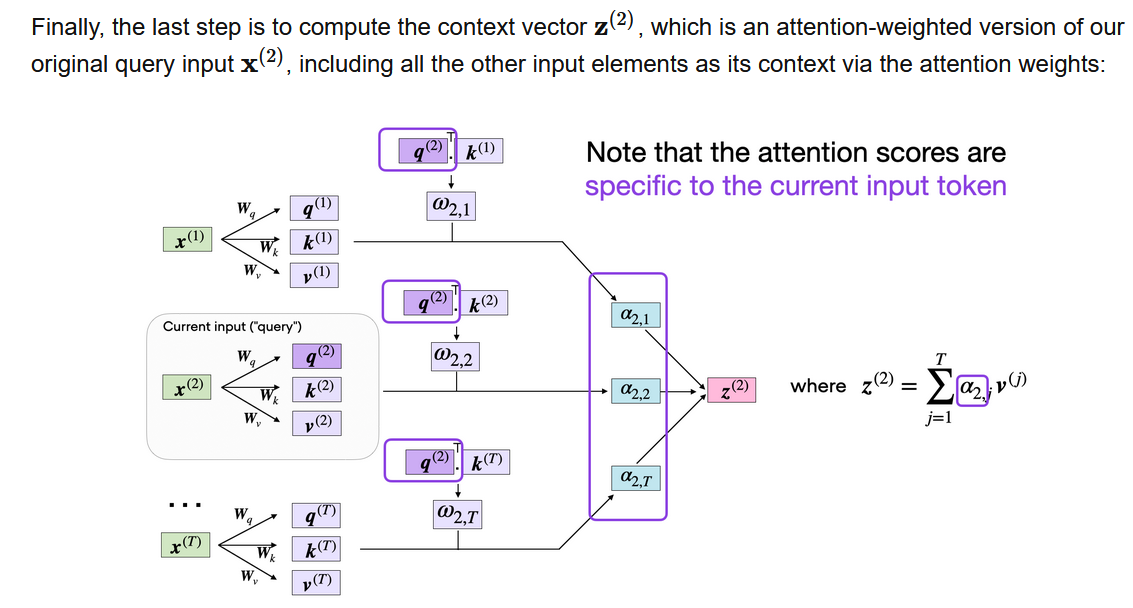

In [15]:
context_vector_2 = attention_weights_2.matmul(values)

print(context_vector_2.shape)
print(context_vector_2)


torch.Size([28])
tensor([-1.5993,  0.0156,  1.2670,  0.0032, -0.6460, -1.1407, -0.4908, -1.4632,
         0.4747,  1.1926,  0.4506, -0.7110,  0.0602,  0.7125, -0.1628, -2.0184,
         0.3838, -2.1188, -0.8136, -1.5694,  0.7934, -0.2911, -1.3640, -0.2366,
        -0.9564, -0.5265,  0.0624,  1.7084], grad_fn=<SqueezeBackward4>)


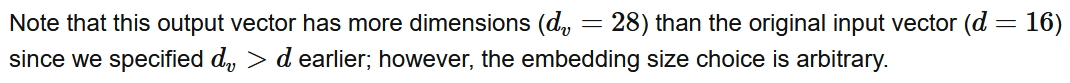

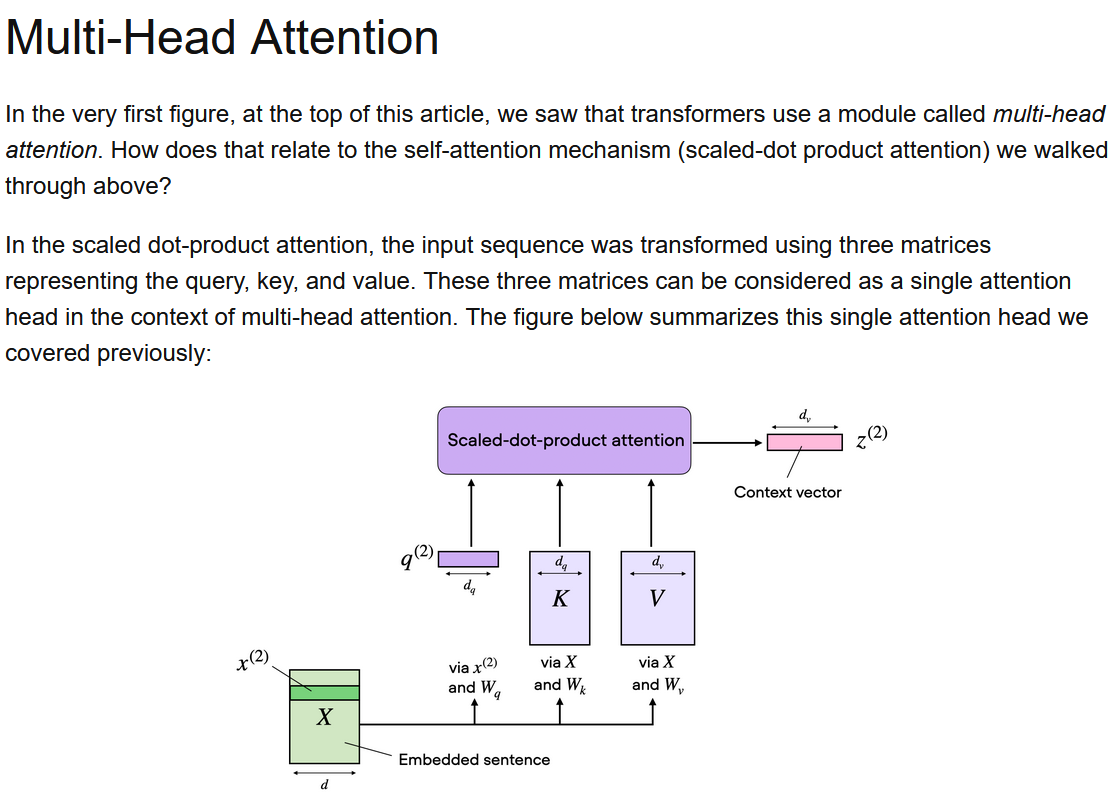

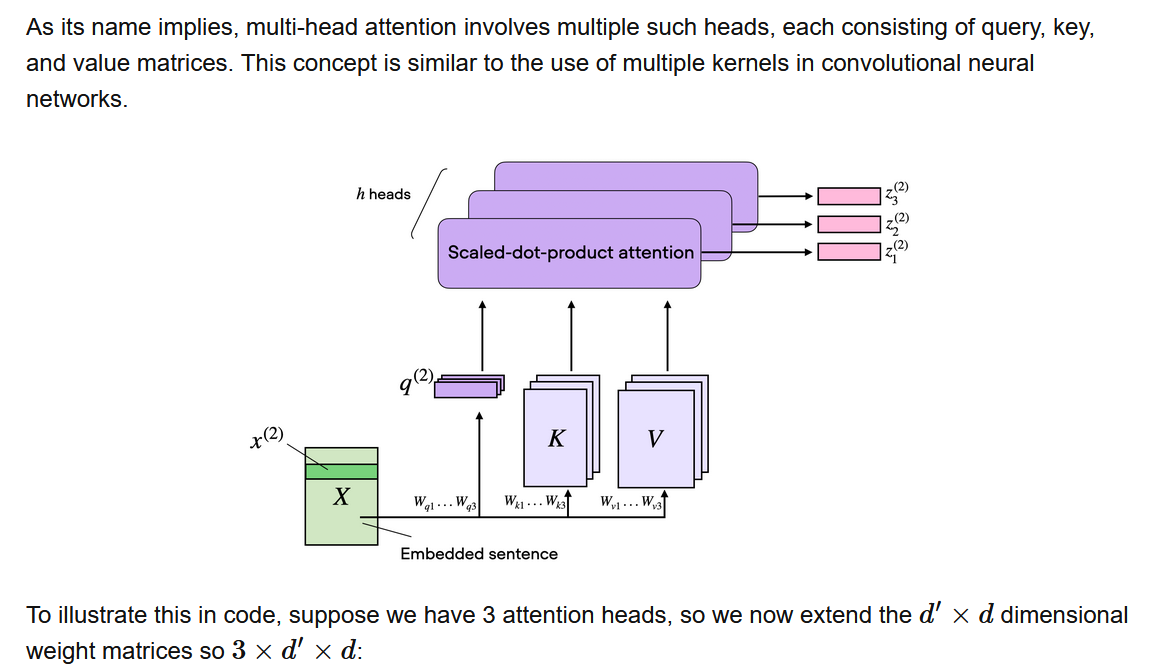

In [16]:
h = 3
multihead_W_query = torch.nn.Parameter(torch.rand(h, d_q, d))
multihead_W_key = torch.nn.Parameter(torch.rand(h, d_k, d))
multihead_W_value = torch.nn.Parameter(torch.rand(h, d_v, d))


In [17]:
multihead_query_2 = multihead_W_query.matmul(x_2)
print(multihead_query_2.shape)


torch.Size([3, 24])


In [18]:
multihead_key_2 = multihead_W_key.matmul(x_2)
multihead_value_2 = multihead_W_value.matmul(x_2)


Now, these key and value elements are specific to the query element. But, similar to earlier, we will also need the value and keys for the other sequence elements in order to compute the attention scores for the query. We can do this is by expanding the input sequence embeddings to size 3, i.e., the number of attention heads:

In [20]:
stacked_inputs = embedded_sentence.T.repeat(3, 1, 1)
print(stacked_inputs.shape)


torch.Size([3, 16, 6])


In [21]:
# Now, we can compute all the keys and values using via torch.bmm() ( batch matrix multiplication):
multihead_keys = torch.bmm(multihead_W_key, stacked_inputs)
multihead_values = torch.bmm(multihead_W_value, stacked_inputs)
print("multihead_keys.shape:", multihead_keys.shape)
print("multihead_values.shape:", multihead_values.shape)


multihead_keys.shape: torch.Size([3, 24, 6])
multihead_values.shape: torch.Size([3, 28, 6])


We now have tensors that represent the three attention heads in their first dimension. The third and second dimensions refer to the number of words and the embedding size, respectively. To make the values and keys more intuitive to interpret, we will swap the second and third dimensions, resulting in tensors with the same dimensional structure as the original input sequence, embedded_sentence:

In [22]:
multihead_keys = multihead_keys.permute(0, 2, 1)
multihead_values = multihead_values.permute(0, 2, 1)
print("multihead_keys.shape:", multihead_keys.shape)
print("multihead_values.shape:", multihead_values.shape)


multihead_keys.shape: torch.Size([3, 6, 24])
multihead_values.shape: torch.Size([3, 6, 28])


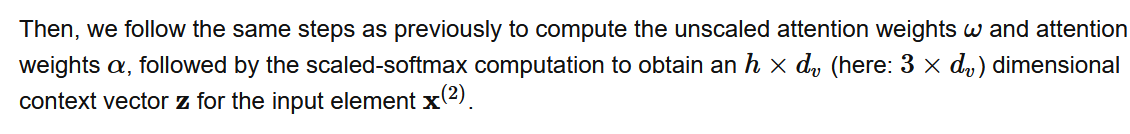